# 어제 오른 내 주식, 과연 내일은?
-  [ Yahoo Finance](https://finance.yahoo.com/?guccounter=1)에서 데이터셋 다운로드 
- 005930.KS.csv 파일

## STEP 1 : 시계열 데이터 준비

###  시계열(Time Series) 생성
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 날짜별(Date)로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있음

In [3]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

-  Date 컬럼을 index로 삼아 시계열을 생성하고
- type 이 DataFrame으로 나오는데
- 시계열(Time Series)은 시간 컬럼을 index로 하는 **Series**로 표현하기 때문에
- time series 의 이니셜을 따서 ts 
- 종가(Close)를 사용할것이고 
- Close만 Series 객체로 변환

## STEP 2 : 각종 전처리 수행
### 1. 결측치 처리

In [20]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

- 결측치가 없는 것으로 확인됨
- 만약 데이터가 있으면 보간(결측치 양옆의 값들을 이용해서 적절히 보간(interpolate))하기 위해 
`ts=ts.interpolate(method='time')` 코드 추가하였음

### 2. 로그 변환

In [22]:
ts_log = np.log(ts)

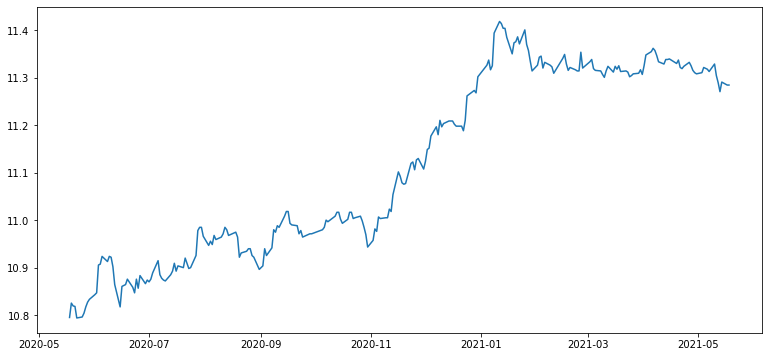

In [23]:
# 그래프 확인
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- 

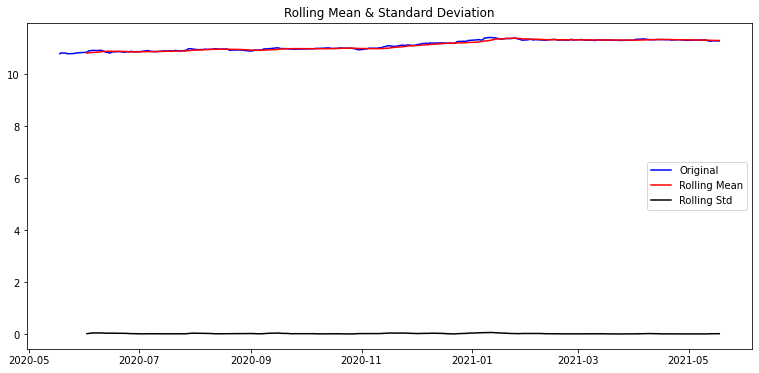

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


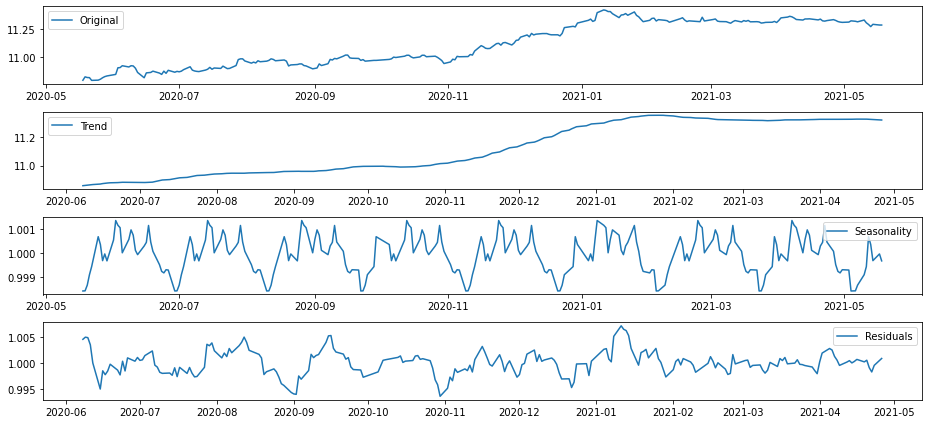

In [24]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [25]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

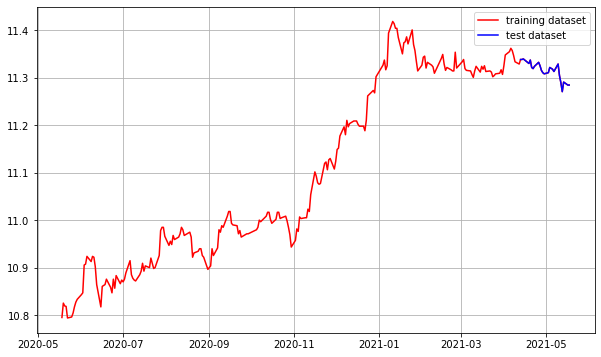

In [26]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
### 1. ACF, PACF 그려보기 -> p,q 구하기

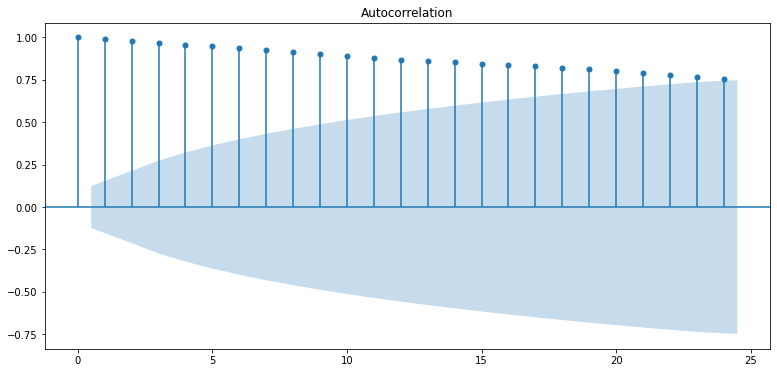

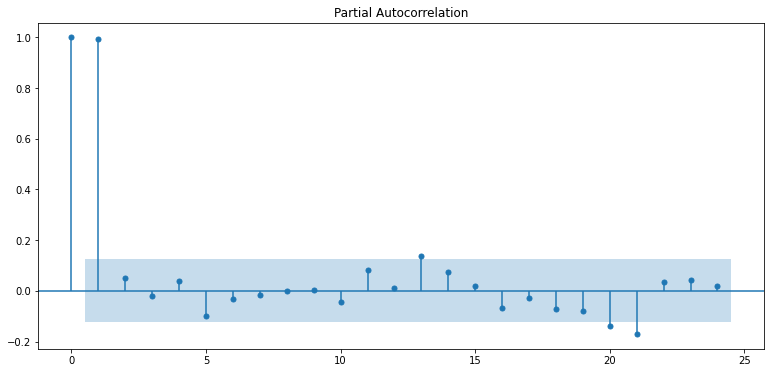

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 2. 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


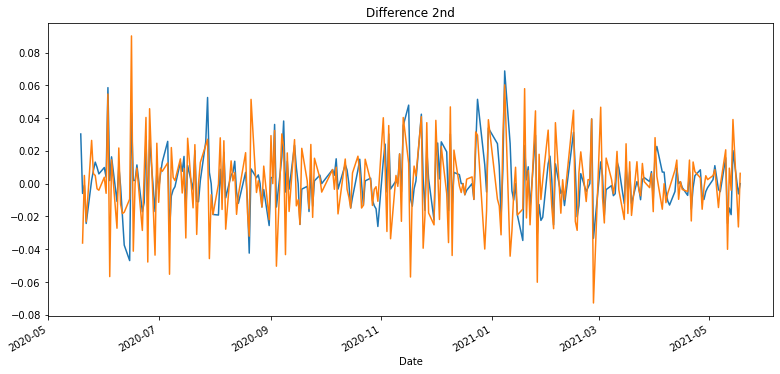

In [30]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

### 6-1. ARIMA 모델 빌드와 훈련

In [31]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 03 Sep 2021   AIC                          -1164.792
Time:                        12:11:42   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 6-2. 모델 테스트 및 플로팅

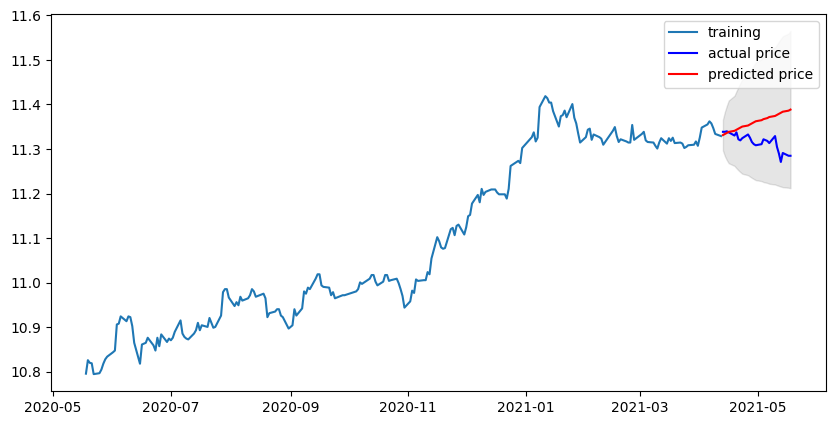

In [32]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 6- 3. 최종 예측 모델 정확도 측정(MAPE)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


## STEP 7 : 다른 주식 종목 예측해 보기
- 대한항공(003490.KS.csv)
- 보령제약(003850.KS.csv)
- 카카오(035720.KS.csv)

In [3]:
#시계열 생성

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/EXPLORATION_project/EX14/003490.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-03,14951.375977,15031.330078,14711.514648,14791.468750,14791.468750,2302876
1,2020-09-04,14471.652344,15111.284180,14431.675781,14871.421875,14871.421875,2607381
2,2020-09-07,14911.399414,15071.306641,14711.514648,14951.375977,14951.375977,2225656
3,2020-09-08,14951.375977,15031.330078,14791.468750,14991.352539,14991.352539,1683277
4,2020-09-09,14911.399414,14951.375977,14711.514648,14711.514648,14711.514648,1671209


In [4]:
# 종가만 사용

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-09-03    14791.468750
2020-09-04    14871.421875
2020-09-07    14951.375977
2020-09-08    14991.352539
2020-09-09    14711.514648
Name: Close, dtype: float64

In [5]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

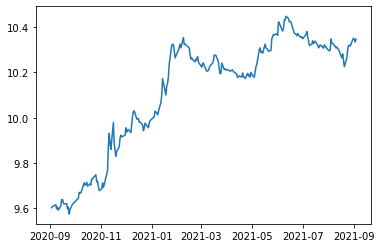

In [7]:
# 로그변환
ts_log = np.log(ts)
# 그래프 확인
plt.plot(ts_log)

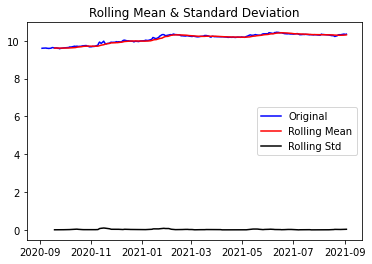

Results of Dickey-Fuller Test:
Test Statistic                  -1.876466
p-value                          0.343212
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


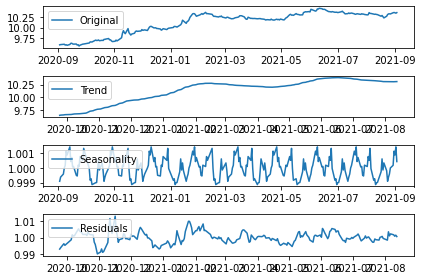

In [10]:
# 시계열 안정성 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [11]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.505495
p-value                          0.000002
#Lags Used                       1.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


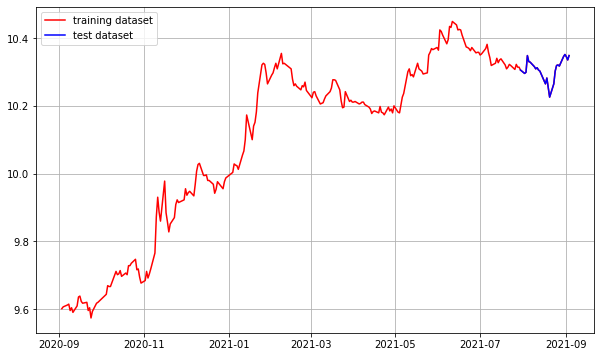

In [12]:
# 학습,테스트셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

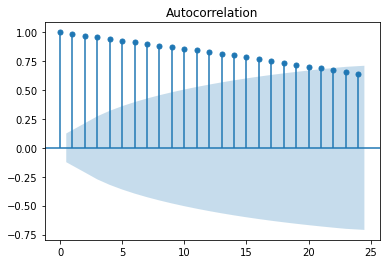

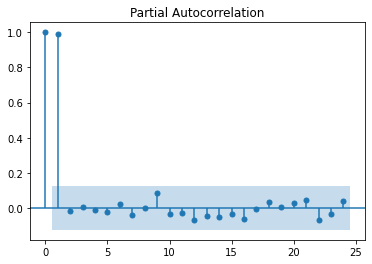

Results of Dickey-Fuller Test:
Test Statistic                -1.503016e+01
p-value                        9.929677e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.140485e+00
p-value                        1.031366e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


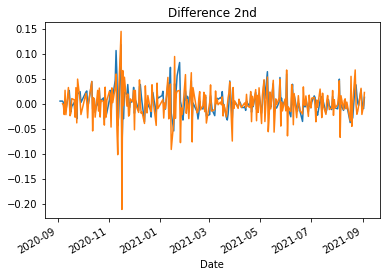

In [14]:
# 적정 ARIMA 모수 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [15]:
#ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 510.771
Method:                       css-mle   S.D. of innovations              0.024
Date:                Fri, 03 Sep 2021   AIC                          -1015.541
Time:                        14:41:48   BIC                          -1005.320
Sample:                             1   HQIC                         -1011.415
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.002      1.867      0.062      -0.000       0.007
ar.L1.D.Close     0.0411      0.067      0.615      0.538      -0.090       0.172
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


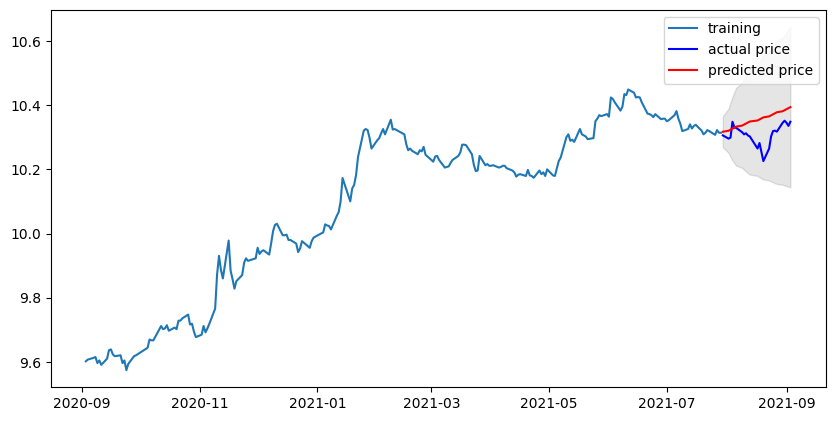

In [16]:
# 모델링 테스트와 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [17]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3068812.037958837
MAE:  1468.8120352247006
RMSE:  1751.8025111178592
MAPE: 4.97%


## @ 보령제약

In [18]:
# 시계열 생성(보령제약)
dataset_filepath = os.getenv('HOME')+'/aiffel/EXPLORATION_project/EX14/003850.KS.csv' 
df = pd.read_csv(dataset_filepath) 

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-09-03    12482.467773
2020-09-04    12482.467773
2020-09-07    12482.467773
2020-09-08    12371.016602
2020-09-09    12073.815430
Name: Close, dtype: float64

In [19]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

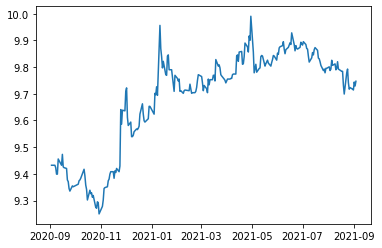

In [20]:
# 로그변환
ts_log = np.log(ts)
# 그래프 확인
plt.plot(ts_log)

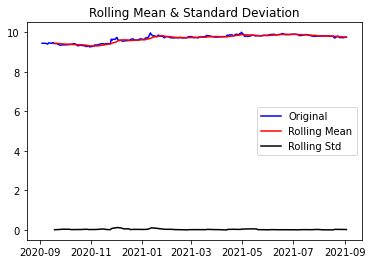

Results of Dickey-Fuller Test:
Test Statistic                  -1.421993
p-value                          0.571688
#Lags Used                       6.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


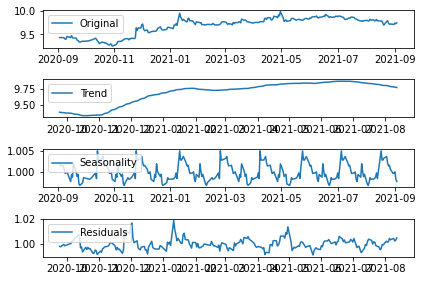

In [21]:
# 시계열 안정성 분석

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [22]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.728602
p-value                          0.000074
#Lags Used                      13.000000
Number of Observations Used    205.000000
Critical Value (1%)             -3.462658
Critical Value (5%)             -2.875744
Critical Value (10%)            -2.574341
dtype: float64


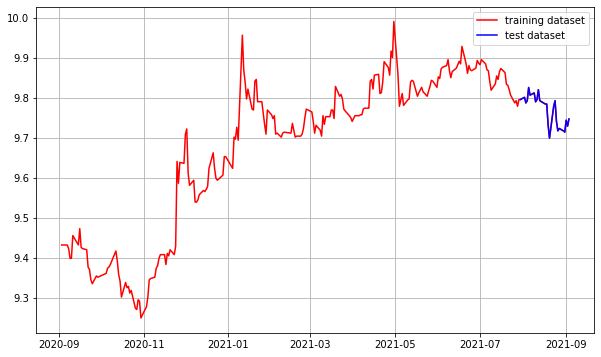

In [23]:
# 학습데이터 분리 
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

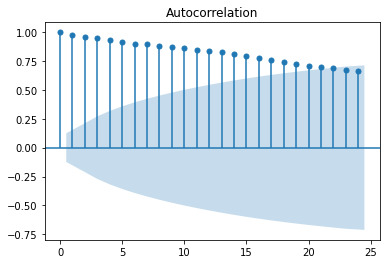

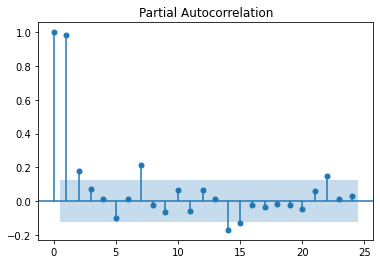

Results of Dickey-Fuller Test:
Test Statistic                -7.836445e+00
p-value                        6.097163e-12
#Lags Used                     5.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.634819e+00
p-value                        5.627884e-14
#Lags Used                     1.200000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


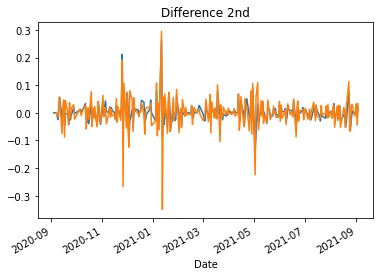

In [24]:
# 적정 ARIMA 모수 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [25]:
#ARIMA 모델 빌드와 훈련
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 424.126
Method:                       css-mle   S.D. of innovations              0.036
Date:                Fri, 03 Sep 2021   AIC                           -842.253
Time:                        14:52:24   BIC                           -832.031
Sample:                             1   HQIC                          -838.126
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.002      0.799      0.424      -0.002       0.006
ar.L1.D.Close    -0.1945      0.066     -2.967      0.003      -0.323      -0.066
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


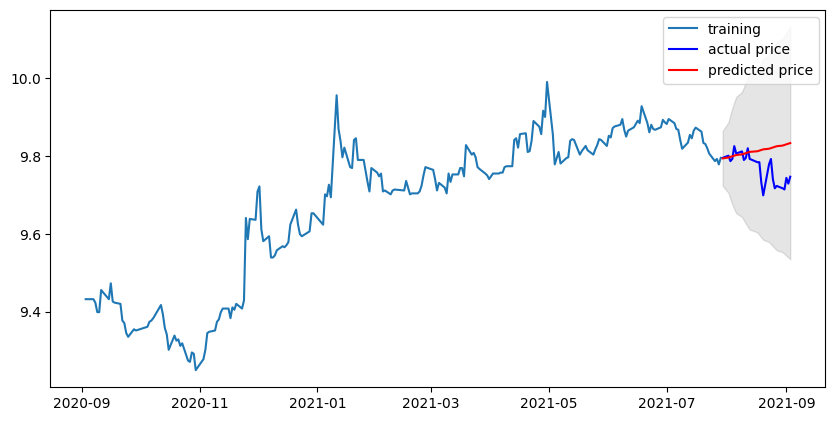

In [26]:
# 모델링 테스트와 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [27]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1309795.382327146
MAE:  872.9501237267581
RMSE:  1144.4629230897547
MAPE: 5.15%


## @ 카카오

In [29]:
#시계열 생성(카카오)

dataset_filepath = os.getenv('HOME')+'/aiffel/EXPLORATION_project/EX14/035720.KS.csv' 
df = pd.read_csv(dataset_filepath) 

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-09-03    82000.0
2020-09-04    80400.0
2020-09-07    78400.0
2020-09-08    78000.0
2020-09-09    76800.0
Name: Close, dtype: float64

In [30]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

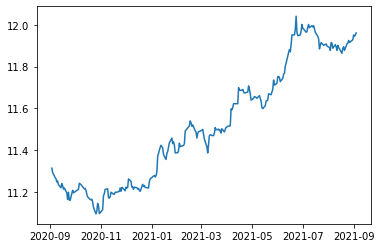

In [31]:
# 로그변환
ts_log = np.log(ts)
# 그래프 확인
plt.plot(ts_log)

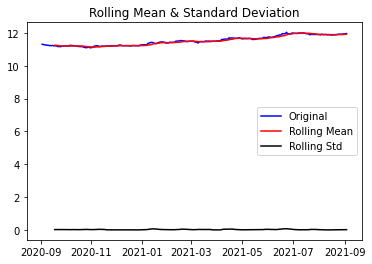

Results of Dickey-Fuller Test:
Test Statistic                   0.122127
p-value                          0.967540
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


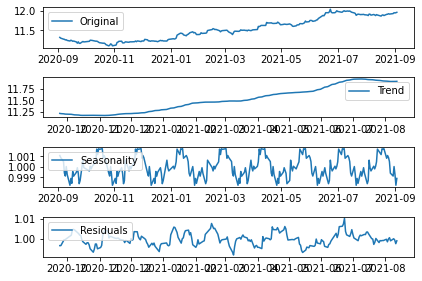

In [33]:
# 시계열 안정성 분석

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [34]:
#Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.354209
p-value                          0.000004
#Lags Used                       1.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


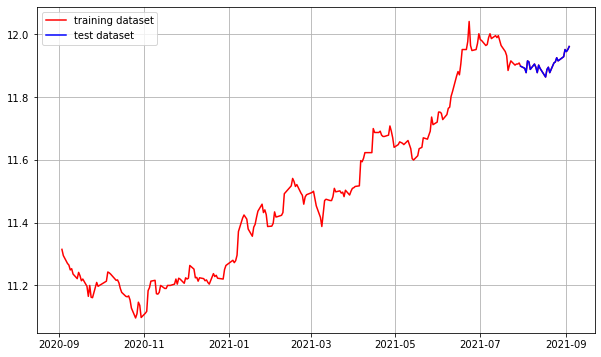

In [35]:
# 학습데이터 분리 
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

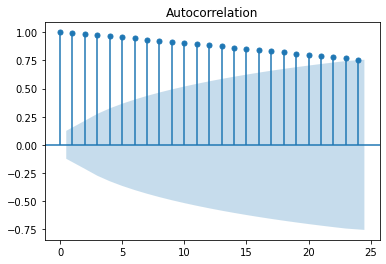

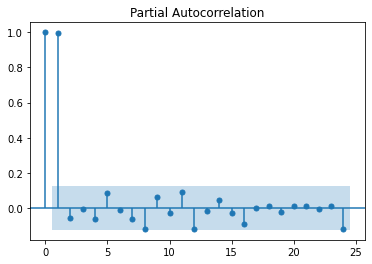

Results of Dickey-Fuller Test:
Test Statistic                -1.468064e+01
p-value                        3.160190e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


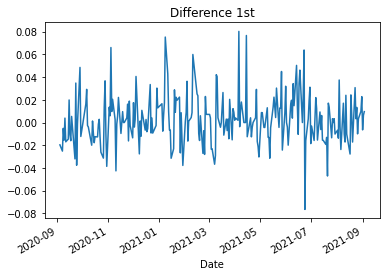

In [46]:
# 적정 ARIMA 모수 찾기

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [47]:
#ARIMA 모델 빌드와 훈련

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 531.916
Method:                       css-mle   S.D. of innovations              0.022
Date:                Fri, 03 Sep 2021   AIC                          -1057.832
Time:                        15:05:32   BIC                          -1047.611
Sample:                             1   HQIC                         -1053.706
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0027      0.002      1.617      0.106      -0.001       0.006
ar.L1.D.Close     0.0912      0.067      1.367      0.172      -0.040       0.222
                                    Root

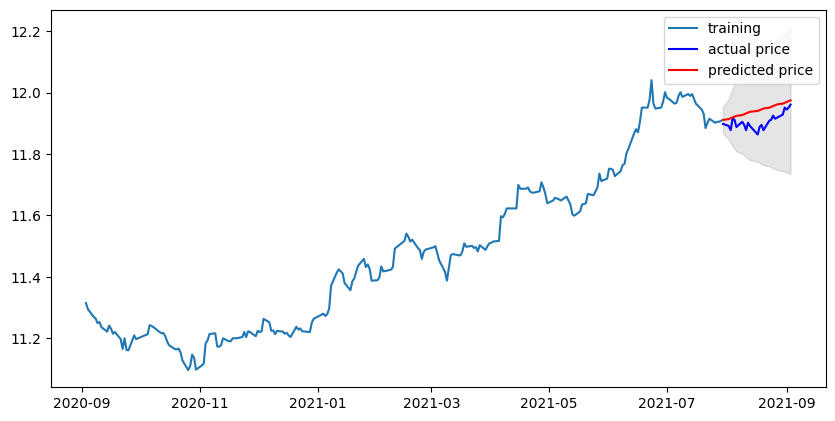

In [48]:
# 모델링 테스트와 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [49]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  35201049.69505785
MAE:  5310.821717687005
RMSE:  5933.0472520499825
MAPE: 3.61%


### 최종 결과

- 대한항공 : MAPE: 4.97% 로 나왔으며 결과적으로는 비슷한 모습으로 올라가고있었다.
- 보령제약 : MAPE: 5.15% 로 나왔으며 예상과는 다른 모습이었다.
- 카카오 : MAPE: 3.61% 나오고 상향하는 것으로 비슷한 모습으로 올라가고 있었다. 

### 회고
대한항공, 보령제약, 카카오 모두 코로나에 영향을 많이 받는 종목이라, 전세계적인 코로나 환자 수, 혹은 사망수 등의 데이터와 함께 비교하면 예상할수있는 값이 조금더 현재와 가까워질것이라 생각해보았다.